In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
from joblib import dump, load

In [2]:
DATA_PATH = "data/metrics.db"

In [3]:
def load_data(data_path):
    conn = sqlite3.connect(data_path)
    
    query = '''
            SELECT numberLinesOfCodeBef, numberCommentsBef, numberBlankLinesBef, totalLinesBef, numParametersBef,
                numStatementsBef, halsteadLengthBef, halsteadVocabularyBef, halsteadVolumeBef, halsteadDifficultyBef,
                halsteadEffortBef, halsteadLevelBef, halsteadTimeBef, halsteadBugsDeliveredBef, halsteadMaintainabilityBef,
                cyclomaticComplexityBef, cognitiveComplexityBef, lackOfCohesionInMethodBef, numberLinesOfCodeAft,
                numberCommentsAft, numberBlankLinesAft, totalLinesAft, numParametersAft, numStatementsAft,
                halsteadLengthAft, halsteadVocabularyAft, halsteadVolumeAft, halsteadDifficultyAft,
                halsteadEffortAft, halsteadLevelAft, halsteadTimeAft, halsteadBugsDeliveredAft,
                halsteadMaintainabilityAft, cyclomaticComplexityAft, cognitiveComplexityAft,
                lackOfCohesionInMethodAft
            FROM methodMetrics;
    '''

    df = pd.read_sql_query(query, conn)
    
    conn.close()
    
    return df

In [30]:
data = load_data(DATA_PATH)
data.head()

,numberLinesOfCodeBef,numberCommentsBef,numberBlankLinesBef,totalLinesBef,numParametersBef,numStatementsBef,halsteadLengthBef,halsteadVocabularyBef,halsteadVolumeBef,halsteadDifficultyBef,...,halsteadVolumeAft,halsteadDifficultyAft,halsteadEffortAft,halsteadLevelAft,halsteadTimeAft,halsteadBugsDeliveredAft,halsteadMaintainabilityAft,cyclomaticComplexityAft,cognitiveComplexityAft,lackOfCohesionInMethodAft
0,57,0,5,62,2,55,77.0,321.0,482.542564,14.721973,...,104.041925,2.145161,223.186710,0.466165,12.399262,0.000333,75.333072,1,1,1.000000
1,4,0,2,6,2,2,45.0,91.0,247.133389,8.419355,...,104.041925,2.015152,209.660243,0.496241,11.647791,0.000333,75.333072,1,1,1.000000
2,3,0,2,5,2,1,21.0,36.0,92.238666,1.451613,...,104.041925,2.145161,223.186710,0.466165,12.399262,0.000333,75.333072,1,1,1.000000
3,3,0,0,3,1,1,29.0,40.0,140.881449,5.537037,...,122.211433,5.055556,617.846687,0.197802,34.324816,0.000333,74.843607,1,1,0.333333
4,11,0,0,11,2,6,26.0,49.0,122.211433,3.405405,...,80.710623,1.956522,157.912088,0.511111,8.772894,0.000333,76.105237,1,1,1.000000


C:\Users\dluis\AppData\Local\Temp\ipykernel_19000\1804200287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_numberLinesOfCode'] = df['numberLinesOfCodeAft'] - df['numberLinesOfCodeBef']
C:\Users\dluis\AppData\Local\Temp\ipykernel_19000\1804200287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_numberComments'] = df['numberCommentsAft'] - df['numberCommentsBef']
C:\Users\dluis\AppData\Local\Temp\ipykernel_19000\1804200287.py:5: SettingWithCopyWarning: 
A value is trying to be set o

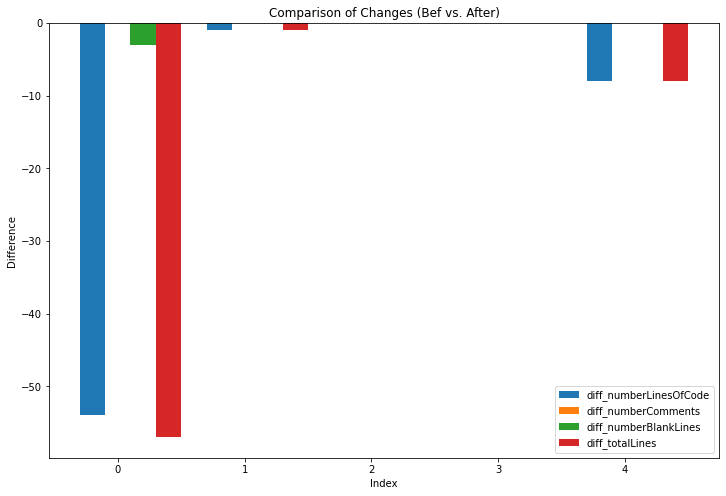

In [15]:
df = data.head()

df['diff_numberLinesOfCode'] = df['numberLinesOfCodeAft'] - df['numberLinesOfCodeBef']
df['diff_numberComments'] = df['numberCommentsAft'] - df['numberCommentsBef']
df['diff_numberBlankLines'] = df['numberBlankLinesAft'] - df['numberBlankLinesBef']
df['diff_totalLines'] = df['totalLinesAft'] - df['totalLinesBef']

plt.figure(figsize=(12, 8))
diff_columns = ['diff_numberLinesOfCode', 'diff_numberComments', 'diff_numberBlankLines', 'diff_totalLines']
bar_width = 0.2
index = df.index

for i, col in enumerate(diff_columns):
    plt.bar(index + (i * bar_width), df[col], width=bar_width, label=col)

plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('Comparison of Changes (Bef vs. After)')
plt.xticks(index + bar_width, index)
plt.legend(diff_columns)
plt.show()

# Compare LiveRefSara with Real Data

In [4]:
def load_livRefSara_data(data_path):
    conn = sqlite3.connect(data_path)
    
    query = '''
            SELECT *
            FROM metricsLiveRef;
    '''

    df = pd.read_sql_query(query, conn)
    
    conn.close()
    
    return df

In [5]:
lrs_data = load_livRefSara_data(DATA_PATH)
lrs_data.head()

,id,numberLinesOfCode,numberComments,numberBlankLines,totalLines,numParameters,numStatements,halsteadLength,halsteadVocabulary,halsteadVolume,halsteadDifficulty,halsteadEffort,halsteadLevel,halsteadTime,halsteadBugsDelivered,halsteadMaintainability,cyclomaticComplexity,cognitiveComplexity,lackOfCohesionInMethod,sameBeforeAfter
0,24145,30.0,0.0,1.0,31.0,0.0,18.0,73.0,268.0,451.857193,16.432584,7425.181399,0.060855,412.510078,0.000333,49.053274,1.0,1.0,1.0,1
1,24146,17.0,0.0,5.0,22.0,0.0,15.0,65.0,200.0,391.453908,14.105263,5521.560384,0.070896,306.753355,0.000333,54.736042,2.0,2.0,0.0,0
2,24147,25.0,0.0,0.0,25.0,1.0,14.0,47.0,204.0,261.065676,9.804348,2559.578693,0.101996,142.198816,0.000333,52.045262,4.0,2.0,1.0,0
3,24148,7.0,0.0,0.0,7.0,1.0,5.0,26.0,53.0,122.211433,4.486111,548.254066,0.222910,30.458559,0.000333,66.547568,3.0,2.0,1.0,0
4,24149,25.0,0.0,0.0,25.0,1.0,14.0,47.0,204.0,261.065676,9.804348,2559.578693,0.101996,142.198816,0.000333,52.045262,4.0,2.0,1.0,0


### Compare predicitons

In [6]:
len(lrs_data)

786

In [7]:
no_pred = lrs_data[lrs_data['numberLinesOfCode'].isnull()]
len(no_pred)

346

In [8]:
pred = lrs_data[lrs_data['numberLinesOfCode'].notnull()]
len(pred)

440

In [9]:
len(pred) / len(lrs_data) * 100

55.97964376590331

### Compare effectiveness

In [10]:
lrs_data.columns

Index(['id', 'numberLinesOfCode', 'numberComments', 'numberBlankLines',
       'totalLines', 'numParameters', 'numStatements', 'halsteadLength',
       'halsteadVocabulary', 'halsteadVolume', 'halsteadDifficulty',
       'halsteadEffort', 'halsteadLevel', 'halsteadTime',
       'halsteadBugsDelivered', 'halsteadMaintainability',
       'cyclomaticComplexity', 'cognitiveComplexity', 'lackOfCohesionInMethod',
       'sameBeforeAfter'],
      dtype='object')

In [13]:
# Connect to the SQLite database
conn = sqlite3.connect(DATA_PATH)

# Read the tables into pandas DataFrames
df_methodMetrics = pd.read_sql_query("SELECT * FROM methodMetrics", conn)
df_metricsLiveRef = pd.read_sql_query("SELECT * FROM metricsLiveRef", conn)

# Rename columns in metricsLiveRef to append 'Sara', except the 'id' column
df_metricsLiveRef = df_metricsLiveRef.rename(columns=lambda x: x + 'Sara' if x != 'id' else x)

# Merge the DataFrames on the 'id' column
result_df = pd.merge(df_metricsLiveRef, df_methodMetrics, on='id', how='inner')

# Display the resulting DataFrame
print(result_df)

# Close the connection
conn.close()

        id  numberLinesOfCodeSara  numberCommentsSara  numberBlankLinesSara  \
0    24145                   30.0                 0.0                   1.0   
1    24146                   17.0                 0.0                   5.0   
2    24147                   25.0                 0.0                   0.0   
3    24148                    7.0                 0.0                   0.0   
4    24149                   25.0                 0.0                   0.0   
..     ...                    ...                 ...                   ...   
781  24950                    NaN                 NaN                   NaN   
782  24951                    NaN                 NaN                   NaN   
783  24952                  197.0                29.0                  45.0   
784  24953                    NaN                 NaN                   NaN   
785  24954                    NaN                 NaN                   NaN   

     totalLinesSara  numParametersSara  numStatemen

In [16]:
# Calculate the differences for tool A (Aft - Bef)
metrics_columns = [col.replace('Aft', '') for col in df_methodMetrics.columns if 'Aft' in col]

for metric in metrics_columns:
    result_df[f'{metric}_diff_A'] = result_df[f'{metric}Aft'] - result_df[f'{metric}Bef']

# Calculate the differences for tool B (Sara - Bef)
for metric in metrics_columns:
    result_df[f'{metric}_diff_B'] = result_df[f'{metric}Sara'] - result_df[f'{metric}Bef']

# Calculate the average reduction for each metric
avg_reduction_A = result_df[[f'{metric}_diff_A' for metric in metrics_columns]].mean()
avg_reduction_B = result_df[[f'{metric}_diff_B' for metric in metrics_columns]].mean()

# Combine the results into a DataFrame for easier comparison
comparison_df = pd.DataFrame({
    'Metric': metrics_columns,
    'Average Reduction Real': avg_reduction_A.values,
    'Average Reduction LiveRef': avg_reduction_B.values
})

# Print the comparison DataFrame
print(comparison_df)

                     Metric  Average Reduction Real  Average Reduction LiveRef
0         numberLinesOfCode              -11.081425                  -9.154545
1            numberComments               -0.445293                  -0.120455
2          numberBlankLines               -1.853690                  -0.470455
3                totalLines              -13.380407                  -9.745455
4             numParameters                0.000000                   0.000000
5             numStatements               -9.424936                  -7.715909
6            halsteadLength              -11.541985                  -9.979545
7        halsteadVocabulary              -87.536896                 -77.020455
8            halsteadVolume              -85.743477                 -75.021855
9        halsteadDifficulty               -2.859876                  -2.602830
10           halsteadEffort            -2763.384101               -2440.331188
11            halsteadLevel                0.064443 

# Compare LiveRefDiogo with Real Data

In [12]:
def load_liveRefDiogo_data(path):
    conn = sqlite3.connect(path)
    
    query = '''
            SELECT *
            FROM metricsLiveRefNew;
    '''

    df = pd.read_sql_query(query, conn)
    
    conn.close()
    
    return df

### One Class SVM

In [90]:
svm_path = "Comparison data/EM - one_class_SVM.db"

In [91]:
lrd_svm = load_liveRefDiogo_data(svm_path)
lrd_svm.head()

,id,extracted,sameBeforeAfter
0,1,1,1
1,2,1,0
2,3,1,0
3,4,0,0
4,5,1,0


In [92]:
len(lrd_svm)

786

In [93]:
no_pred_svm = lrd_svm[lrd_svm['extracted'] == 0]
len(no_pred_svm)

353

In [94]:
pred_svm = lrd_svm[lrd_svm['extracted'] == 1]
len(pred_svm)

433

In [95]:
len(pred_svm) / len(lrd_svm) * 100

55.089058524173026

### Elliptic Envelope

In [83]:
ee_path = "Comparison data/EM - elliptic envelope.db"

In [84]:
lrd_ee = load_liveRefDiogo_data(ee_path)
lrd_ee.head()

,id,extracted,sameBeforeAfter
0,1,0,0
1,2,1,1
2,3,1,0
3,4,1,0
4,5,0,0


In [85]:
len(lrd_ee)

786

In [86]:
no_pred_ee = lrd_ee[lrd_ee['extracted'] == 0]
len(no_pred_ee)

303

In [87]:
pred_ee = lrd_ee[lrd_ee['extracted'] == 1]
len(pred_ee)

483

In [88]:
len(pred_ee) / len(lrd_ee) * 100

61.45038167938931